<a href="https://colab.research.google.com/github/AmadeusAlcantara/GitTrainingWall/blob/master/CNN_Classifier_Topological_Design.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning exercise -  Classify Topological Designs 

Predictive Multiscale Materials Design Short Course

June 21-25, 2021

Markus J. Buehler, MIT

In [1]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

#import libraries
import tensorflow_hub as hub
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import layers
import numpy as np
import keras 
from tensorflow.keras.models import load_model
import tensorflow as tf

print(tf.__version__)

if tf.test.gpu_device_name(): 
 print('Default GPU Device:  {}'.format(tf.test.gpu_device_name()))

else:
   print("You should install GPU version of TF")
 

2.5.0
Default GPU Device:  /device:GPU:0


In [2]:
!nvidia-smi

Wed Jun 23 19:23:28 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P0    31W /  70W |    222MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!wget -O Day3TopOptClass.zip https://www.dropbox.com/s/fl14m9bsnkyoxnj/Day3TopOptClass.zip?dl=0
!unzip Day3TopOptClass.zip    

--2021-06-23 19:23:45--  https://www.dropbox.com/s/fl14m9bsnkyoxnj/Day3TopOptClass.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/fl14m9bsnkyoxnj/Day3TopOptClass.zip [following]
--2021-06-23 19:23:45--  https://www.dropbox.com/s/raw/fl14m9bsnkyoxnj/Day3TopOptClass.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucd5a0e4b291bd17d3c728174c4d.dl.dropboxusercontent.com/cd/0/inline/BQ87_Ha9NGgg3bcKDmN7I6pSwidV1VczF9ZWS8VCp0D-ae93AXDZYyXPlwMDBf112bVP__a2mo9ixwLtKmUS2vJ3K90fFExn0rHYF_UpiTyI2Oc19nN0mbDJAjDe-PJLhUPPifgxd4qHd8PKMLNUrKBt/file# [following]
--2021-06-23 19:23:45--  https://ucd5a0e4b291bd17d3c728174c4d.dl.dropboxusercontent.com/cd/0/inline/BQ87_Ha9NGgg3bcKDmN7I6pSwidV1VczF9ZWS8VCp0D-ae93AXDZYyXPlwMDBf11

In [6]:
!ls

Day3TopOptClass.zip  topopt-1.png  topopt-4.png  topopt-7.png  TopOptData
sample_data	     topopt-2.png  topopt-5.png  topopt-8.png
topopt-10.png	     topopt-3.png  topopt-6.png  topopt-9.png


In [9]:

def load_labels(filename):
  with open(filename, 'r') as f:
    return [line.strip() for line in f.readlines()]

In [10]:
#need to adjust

IMG_SIZE =224
IMAGE_SHAPE= (IMG_SIZE, IMG_SIZE)

In [11]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

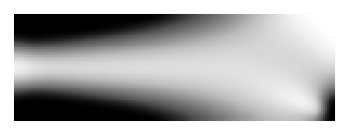

In [12]:
file = "topopt-1.png"
#file = "topopt-2.jpg"
#file = "topopt-3.jpg"

img = mpimg.imread(file)
plt.imshow(img)
plt.axis('off')

img = load_img(file, target_size=(IMG_SIZE,IMG_SIZE))
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = (np.float32(img_array)) / 255.

# Now use transfer learning to improve the model

In [13]:
folder = './TopOptData/'
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
image_data = image_generator.flow_from_directory(directory=folder, target_size=IMAGE_SHAPE)

for image_batch, label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

Found 189 images belonging to 2 classes.
Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 2)


In [14]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4" 
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3))
feature_batch = feature_extractor_layer(img_array)
print(feature_batch.shape)

(1, 1280)


In [15]:
feature_extractor_layer.trainable = False

model = tf.keras.Sequential([
  feature_extractor_layer,
  layers.Dense(image_data.num_classes)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [16]:
predictions = model(img_array)
predictions.shape

TensorShape([1, 2])

In [17]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

In [18]:
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit (image_data, epochs=5,
                              steps_per_epoch=steps_per_epoch,
                              callbacks = [batch_stats_callback])

Epoch 1/5
6/6 [==============================] - 4s 130ms/step - loss: 0.2409 - acc: 0.9062
Epoch 2/5
6/6 [==============================] - 0s 67ms/step - loss: 0.0670 - acc: 1.0000
Epoch 3/5
6/6 [==============================] - 0s 67ms/step - loss: 0.0920 - acc: 0.9688
Epoch 4/5
6/6 [==============================] - 0s 70ms/step - loss: 0.0176 - acc: 1.0000
Epoch 5/5
6/6 [==============================] - 0s 67ms/step - loss: 0.0227 - acc: 1.0000


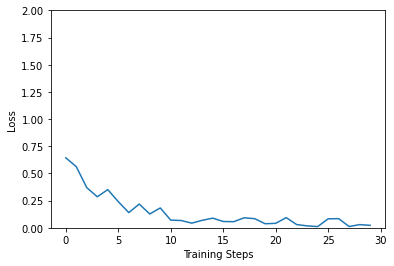

In [19]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

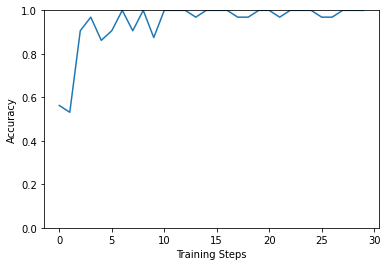

In [20]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

In [21]:
class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

#SAVE MODEL

export_path_ = "./my_model_trained/topopt_model.h5"
#model.save(export_path_)

#export_path

## Let's see if the classifier can detect samples it hasn't seen...

E.g., different resolution of image, aspect ratio, BC

(1, 2)
Highest prediction:  Notoptimized 0 1.0
All predictions:  [ 1. -1.]
All labels:       ['Notoptimized' 'Optimized']


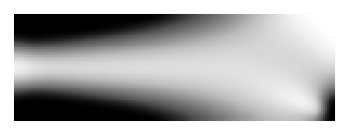

In [22]:
file = "topopt-1.png"
#file = "topopt-2.jpg"
#file = "topopt-3.jpg"

img = mpimg.imread(file)
plt.imshow(img)
plt.axis('off')

img = load_img(file, target_size=(IMG_SIZE,IMG_SIZE))
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = (np.float32(img_array)) / 255.

prediction = model.predict (img_array);
#print (prediction)
maxpos=np.argmax(prediction)
print (prediction.shape)
print ("Highest prediction: ", class_names[maxpos], maxpos, prediction [0,maxpos]/max(prediction[0,:]) )
print ("All predictions: ", prediction [0,:]//max(prediction[0,:]))
print ("All labels:      ", class_names)  

(1, 2)
Highest prediction:  Optimized 1 1.0
All predictions:  [-2.  1.]
All labels:       ['Notoptimized' 'Optimized']


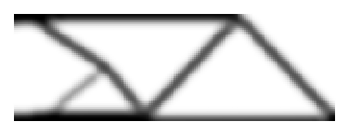

In [23]:
file = "topopt-2.png"
#file = "topopt-2.jpg"
#file = "topopt-3.jpg"

img = mpimg.imread(file)
plt.imshow(img)
plt.axis('off')

img = load_img(file, target_size=(IMG_SIZE,IMG_SIZE))
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = (np.float32(img_array)) / 255.

prediction = model.predict (img_array);
#print (prediction)
maxpos=np.argmax(prediction)
print (prediction.shape)
print ("Highest prediction: ", class_names[maxpos], maxpos, prediction [0,maxpos]/max(prediction[0,:]) )
print ("All predictions: ", prediction [0,:]//max(prediction[0,:]))
print ("All labels:      ", class_names)  

(1, 2)
Highest prediction:  Notoptimized 0 1.0
All predictions:  [ 1. -1.]
All labels:       ['Notoptimized' 'Optimized']


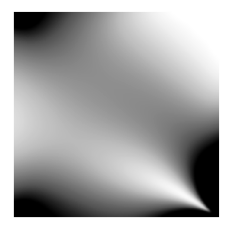

In [24]:
file = "topopt-3.png"
#file = "topopt-2.jpg"
#file = "topopt-3.jpg"

img = mpimg.imread(file)
plt.imshow(img)
plt.axis('off')

img = load_img(file, target_size=(IMG_SIZE,IMG_SIZE))
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = (np.float32(img_array)) / 255.

prediction = model.predict (img_array);
#print (prediction)
maxpos=np.argmax(prediction)
print (prediction.shape)
print ("Highest prediction: ", class_names[maxpos], maxpos, prediction [0,maxpos]/max(prediction[0,:]) )
print ("All predictions: ", prediction [0,:]//max(prediction[0,:]))
print ("All labels:      ", class_names)  

(1, 2)
Highest prediction:  Optimized 1 1.0
All predictions:  [-1.  1.]
All labels:       ['Notoptimized' 'Optimized']


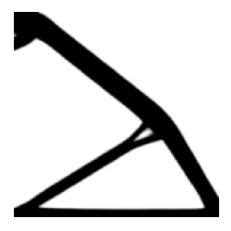

In [25]:
file = "topopt-4.png"
#file = "topopt-2.jpg"
#file = "topopt-3.jpg"

img = mpimg.imread(file)
plt.imshow(img)
plt.axis('off')

img = load_img(file, target_size=(IMG_SIZE,IMG_SIZE))
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = (np.float32(img_array)) / 255.

prediction = model.predict (img_array);
#print (prediction)
maxpos=np.argmax(prediction)
print (prediction.shape)
print ("Highest prediction: ", class_names[maxpos], maxpos, prediction [0,maxpos]/max(prediction[0,:]) )
print ("All predictions: ", prediction [0,:]//max(prediction[0,:]))
print ("All labels:      ", class_names)  

(1, 2)
Highest prediction:  Notoptimized 0 1.0
All predictions:  [ 1. -1.]
All labels:       ['Notoptimized' 'Optimized']


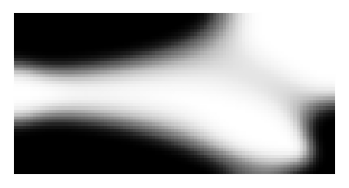

In [26]:
file = "topopt-5.png"
#file = "topopt-2.jpg"
#file = "topopt-3.jpg"

img = mpimg.imread(file)
plt.imshow(img)
plt.axis('off')

img = load_img(file, target_size=(IMG_SIZE,IMG_SIZE))
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = (np.float32(img_array)) / 255.

prediction = model.predict (img_array);
#print (prediction)
maxpos=np.argmax(prediction)
print (prediction.shape)
print ("Highest prediction: ", class_names[maxpos], maxpos, prediction [0,maxpos]/max(prediction[0,:]) )
print ("All predictions: ", prediction [0,:]//max(prediction[0,:]))
print ("All labels:      ", class_names)  

(1, 2)
Highest prediction:  Notoptimized 0 1.0
All predictions:  [ 1. -1.]
All labels:       ['Notoptimized' 'Optimized']


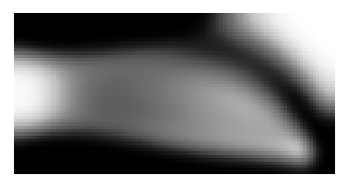

In [27]:
file = "topopt-6.png"
#file = "topopt-2.jpg"
#file = "topopt-3.jpg"

img = mpimg.imread(file)
plt.imshow(img)
plt.axis('off')

img = load_img(file, target_size=(IMG_SIZE,IMG_SIZE))
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = (np.float32(img_array)) / 255.

prediction = model.predict (img_array);
#print (prediction)
maxpos=np.argmax(prediction)
print (prediction.shape)
print ("Highest prediction: ", class_names[maxpos], maxpos, prediction [0,maxpos]/max(prediction[0,:]) )
print ("All predictions: ", prediction [0,:]//max(prediction[0,:]))
print ("All labels:      ", class_names)  

(1, 2)
Highest prediction:  Optimized 1 1.0
All predictions:  [-1.  1.]
All labels:       ['Notoptimized' 'Optimized']


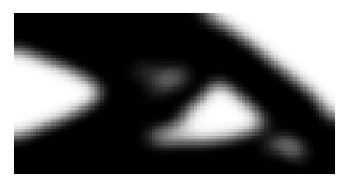

In [28]:
file = "topopt-7.png"
#file = "topopt-2.jpg"
#file = "topopt-3.jpg"

img = mpimg.imread(file)
plt.imshow(img)
plt.axis('off')

img = load_img(file, target_size=(IMG_SIZE,IMG_SIZE))
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = (np.float32(img_array)) / 255.

prediction = model.predict (img_array);
#print (prediction)
maxpos=np.argmax(prediction)
print (prediction.shape)
print ("Highest prediction: ", class_names[maxpos], maxpos, prediction [0,maxpos]/max(prediction[0,:]) )
print ("All predictions: ", prediction [0,:]//max(prediction[0,:]))
print ("All labels:      ", class_names)  

(1, 2)
Highest prediction:  Notoptimized 0 1.0
All predictions:  [1. 0.]
All labels:       ['Notoptimized' 'Optimized']


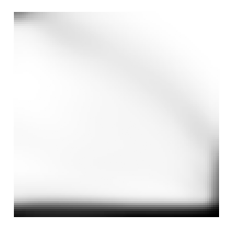

In [29]:
file = "topopt-8.png"
#file = "topopt-2.jpg"
#file = "topopt-3.jpg"

img = mpimg.imread(file)
plt.imshow(img)
plt.axis('off')

img = load_img(file, target_size=(IMG_SIZE,IMG_SIZE))
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = (np.float32(img_array)) / 255.

prediction = model.predict (img_array);
#print (prediction)
maxpos=np.argmax(prediction)
print (prediction.shape)
print ("Highest prediction: ", class_names[maxpos], maxpos, prediction [0,maxpos]/max(prediction[0,:]) )
print ("All predictions: ", prediction [0,:]//max(prediction[0,:]))
print ("All labels:      ", class_names)  

(1, 2)
Highest prediction:  Notoptimized 0 1.0
All predictions:  [ 1. -1.]
All labels:       ['Notoptimized' 'Optimized']


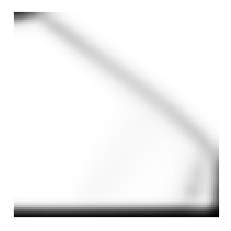

In [30]:
file = "topopt-10.png"
#file = "topopt-2.jpg"
#file = "topopt-3.jpg"

img = mpimg.imread(file)
plt.imshow(img)
plt.axis('off')

img = load_img(file, target_size=(IMG_SIZE,IMG_SIZE))
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = (np.float32(img_array)) / 255.

prediction = model.predict (img_array);
#print (prediction)
maxpos=np.argmax(prediction)
print (prediction.shape)
print ("Highest prediction: ", class_names[maxpos], maxpos, prediction [0,maxpos]/max(prediction[0,:]) )
print ("All predictions: ", prediction [0,:]//max(prediction[0,:]))
print ("All labels:      ", class_names)  